In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('data/default of credit card clients.xls')

#### Cleaning the data and bringing it into proper shape

In [5]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [4]:
# Fixing the column names

columns = df.iloc[0, :]
df.columns = columns
df.drop([0, ], inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [6]:
# converting all the columns to float

for col in columns:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')

In [7]:
print(df.describe())

0                ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

0               AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802

The target variable here is "default payment next month"

Now, the data looks good enough and is clean enough to be used for model building.

### Creating the model

To start things off, lets make a model as is from the given data, and see what kind of accuracy we get.

In [8]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [9]:
x = df[df.columns[1:24]]
y = df['default payment next month']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 33)
model1 = LogisticRegression()
model1.fit(x_train, y_train)

C:\Users\Raghunandan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# Lets check the accuracy now
from sklearn.metrics import confusion_matrix

y_preds_test = model1.predict(x_test)
cm1 = confusion_matrix(y_test, y_preds_test)
print(cm1)

[[4678    0]
 [1322    0]]


The model predicts all the records to not be defaulters. Althought he accuracy of this model is nearly 78%, we cannot use this model, as it has 0 specificity. So we have to attempt to fix this model.
Lets try changing the threshold value to try and get higher specificity.

In [11]:
threshold = 0.4
y_preds_prob = model1.predict_proba(x_test)
y_pred_prob_1 = y_preds_prob[:, 1]
y_preds_class_1 = y_pred_prob_1*0
y_preds_class_1[y_pred_prob_1>threshold] = 1

In [12]:
cm2 = confusion_matrix(y_test, y_preds_class_1)
print(cm2)

[[3859  819]
 [ 851  471]]


In [13]:
accuracy_1 = (cm2[0, 0] + cm2[1, 1])/(cm2[0, 0] + cm2[0, 1] + cm2[1, 0] + cm2[1,1])
specificity_1 = cm2[1, 1]/(cm2[1, 0] + cm2[1, 1])

print(accuracy_1)
print(specificity_1)

0.7216666666666667
0.35627836611195157


We can see that by setting the value of threshold at 0.4, we get an accuracy of ~ 72.2%, and specificity has gone up from 0 to 35.63%.

This still leaves a lot of room for improvement of the model. The specificity and the overall accuracy of the model still need to be improved.

### Improving the model

Now, lets try to see which features actually have a correlation with the target variable.

<AxesSubplot:xlabel='0', ylabel='0'>

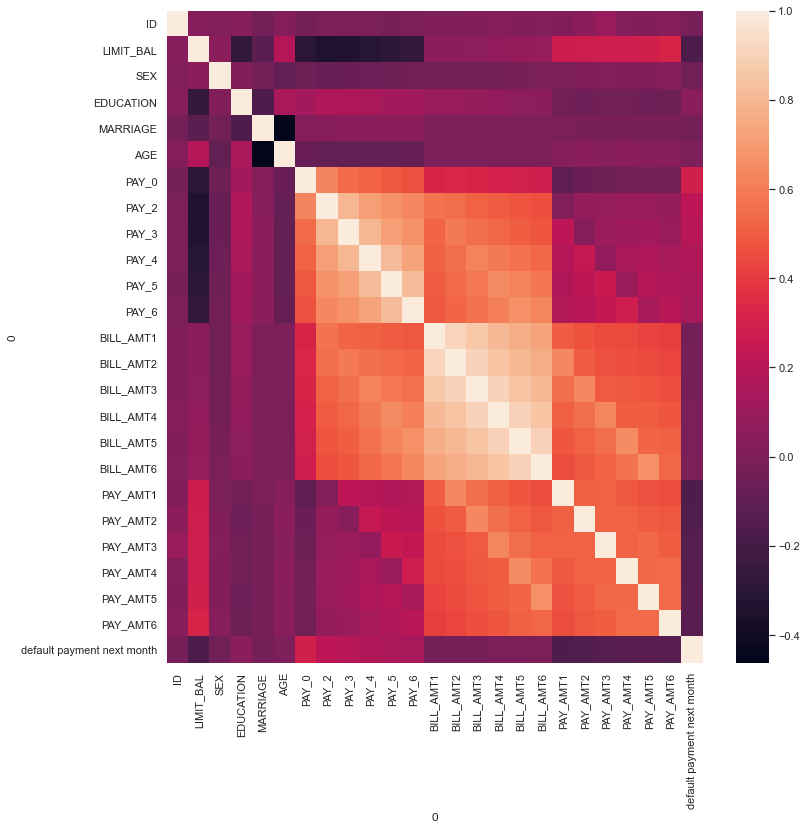

In [46]:
import seaborn as sns

sns.set(rc = {'figure.figsize' : (12, 12)})
sns.heatmap(df.corr(method = 'spearman'))

As we can see from the above heatmap, all the 'BILL_AMT and PAY_AMT features have very little correlation with the target variable. The same can be said about the LIMIT_BAL feature. So, we can try dropping these features, and create the model again.

In [23]:
col_names = df.columns
print(col_names)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)


In [24]:
x_new = df[col_names[2:12]]
y_new = df['default payment next month']

In [25]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size = 0.2, random_state = 25)
model2 = LogisticRegression()
model2.fit(x_train_new, y_train_new)

C:\Users\Raghunandan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
y_preds_test_new = model2.predict(x_test_new)
cm3 = confusion_matrix(y_test_new, y_preds_test_new)
print(cm3)

[[4534  115]
 [1042  309]]


In [27]:
accuracy_2 = (cm3[0, 0] + cm3[1, 1])/(cm3[0, 0] + cm3[0, 1] + cm3[1, 0] + cm3[1,1])
specificity_2 = cm3[1, 1]/(cm3[1, 0] + cm3[1, 1])

print(accuracy_2)
print(specificity_2)

0.8071666666666667
0.22871946706143598


We can see a much better accuracy and specificity in this case. Lets try changing the threshold to see if we can make this even better.

In [35]:
threshold = 0.3
y_preds_prob = model2.predict_proba(x_test_new)
y_pred_prob_2 = y_preds_prob[:, 1]
y_preds_class_2 = y_pred_prob_1*0
y_preds_class_2[y_pred_prob_2>threshold] = 1

In [36]:
cm4 = confusion_matrix(y_test_new, y_preds_class_2)
print(cm4)

[[4238  411]
 [ 724  627]]


In [37]:
accuracy_3 = (cm4[0, 0] + cm4[1, 1])/(cm4[0, 0] + cm4[0, 1] + cm4[1, 0] + cm4[1,1])
specificity_3 = cm4[1, 1]/(cm4[1, 0] + cm4[1, 1])

print(accuracy_3)
print(specificity_3)

0.8108333333333333
0.46410066617320506


We can see that by setting the threshold at 0.3, we get slightly higher accuracy and much higher specificity than before.

We can also compare this model with our previous one using an ROC curve.

#### ROC Curve

In [38]:
from sklearn.metrics import roc_curve, auc

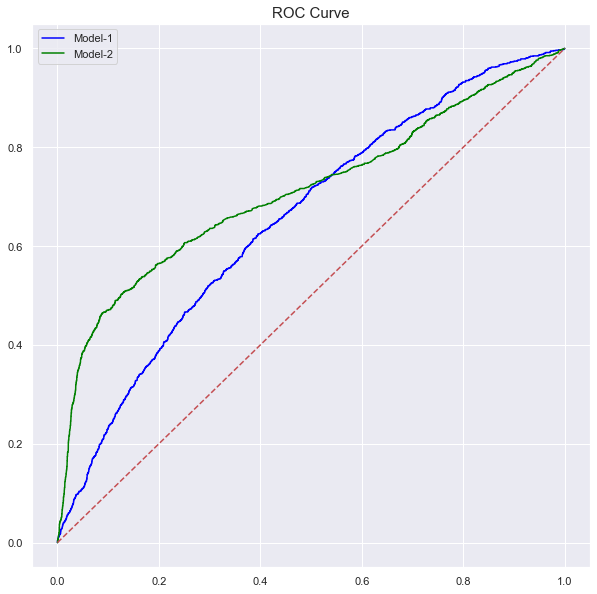

In [42]:
FP_rate_1, TP_rate_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
FP_rate_2, TP_rate_2, thresholds_2 = roc_curve(y_test_new, y_pred_prob_2)

plt.figure(figsize = (10, 10))
plt.plot(FP_rate_1, TP_rate_1, color = 'blue', label = 'Model-1')
plt.plot(FP_rate_2, TP_rate_2, color = 'green', label = 'Model-2')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve', fontsize = 15)
plt.legend()
plt.show()

As we can see, model2, or our newer model, is much much better than the previous model. 
Lets also try and find the AUC for both the graphs.

In [44]:
auc1 = auc(FP_rate_1, TP_rate_1)
auc2 = auc(FP_rate_2, TP_rate_2)

print('AUC for the first model is', auc1, '\nand for the second model is', auc2)

AUC for the first model is 0.6543044533946842 
and for the second model is 0.7102828796145204


As we can see, auc for the second model is closer to 1.0 as compared to the first model, we can declare the second model as being better than the first.